# Установка и импорт

In [ ]:
!pip install gdown

In [ ]:
import gdown
import tensorflow as tf
import pandas as pd
from keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from keras.layers import (Dense, LSTM, Flatten, Conv2D, MaxPooling2D, Input,
                          ConvLSTM2D, Reshape, Embedding, Softmax, GRU, LSTM)
import os
import numpy as np
import re

In [ ]:
url = "https://drive.google.com/file/d/1mjiiHTMvU5l3aSNMuZhNxqxcQSfU9AC2/view?usp=sharing" # Ссылка на скачивание документов для базы
gdown.download(url, quiet = False, fuzzy = True)
del url
!unzip -qq '56198.zip'
!tar -xf formula_images.tar.gz

Downloading...
From (original): https://drive.google.com/uc?id=1mjiiHTMvU5l3aSNMuZhNxqxcQSfU9AC2
From (redirected): https://drive.google.com/uc?id=1mjiiHTMvU5l3aSNMuZhNxqxcQSfU9AC2&confirm=t&uuid=983353ed-1b53-4751-9757-653562a8fb2a
To: /content/56198.zip
100%|██████████| 307M/307M [00:02<00:00, 136MB/s]


# Константы

In [ ]:
images_path = 'formula_images/'
train_path = "im2latex_train.lst"
validation_path = "im2latex_validate.lst"
test_path = "im2latex_test.lst"
img_size = (299,299)
SOS = "<start>"
EOS = "<end>"

# Токенизация

## Читаю LaTeX

In [ ]:
with open("im2latex_formulas.lst", newline="\n", encoding="ISO-8859-1") as file:
  formuls = file.readlines()
# Добавляю SOS EOS
formuls = list(map(lambda x: f"{SOS} {x} {EOS}", formuls))

## Токенизатор

In [ ]:
# Метод ограничения длины последовательности
from keras.preprocessing.sequence import pad_sequences

# Токенайзер
from tensorflow.keras.preprocessing.text import Tokenizer

def tokenize(text): # функция принимает текст на заданном языке
    # Создадим токенайзер
    tokenizer = Tokenizer(filters='')

    # Загружаем в токенизатор тексты для обработки и сборки словаря частотности
    tokenizer.fit_on_texts(text)

    # Векторизируем фразы
    seq = tokenizer.texts_to_sequences(text)

    # Делаем последовательности одной длины, заполняя нулями короткие фразы
    pseq = pad_sequences(seq, padding='post')

    # Возвращаем последовательность индексов и токенизатор
    return pseq, tokenizer

## Получаю последовательности и максимальную длину

In [ ]:
sequenses, tokenizer = tokenize(formuls)
max_length_seq = sequenses.shape[1]

# Собираю выборки

In [ ]:
# Функция получения пути изображения
def get_images(path):
  df = pd.read_csv(path, sep=' ', header=None)
  df.columns=['formula_idx', "image_name", "render_type"]
  df["image_name"] = images_path + df["image_name"] + ".png"
  return df

# Функция получения формулы
def get_formula(df, seq):
  temp = list(map(lambda x: seq[x], df.formula_idx))
  df["formula"] = temp
  df = df.drop(['formula_idx'], axis=1)
  return df['image_name'].values.tolist(), df['formula'].values.tolist()

train_df = get_images(train_path)
X_train, y_train = get_formula(train_df, sequenses)


del get_images, get_formula

### Обрезаю тренировочный набор, при обработке полностью занимает много времени, Google Colab не дает столько

In [ ]:
# X_test = X_train[100:1050]
# y_test = y_train[100:1050]
X_train = X_train[:100]
X_test = X_train.copy()
y_train = y_train[:100]

In [ ]:
from tqdm import tqdm
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Модель
model = InceptionV3(weights='imagenet')
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

# Собираю признаки изображений
for idx, path in tqdm(enumerate(X_train)):
    img = load_img(path,target_size=img_size)
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    # feature = np.reshape(feature, feature.shape[1])
    X_train[idx] = feature

96112376/96112376 [==============================] - 0s 0us/step


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100it [00:16,  5.98it/s]


In [ ]:
# @title Новые константы
BATCH_SIZE     = 32       # размер обучающего пакета.
EPOCHS         = 20        # число эпох обучения.
UNITS          = 512      # число нейронов в рекуррентных с слоях.
EMBED_DIM      = 256       # размерность эмбеддинга.
# NUM_SAMPLES    = 50000     # число примеров для обучения.

# Определим параметры
BUFFER_SIZE = len(X_train)                    # Длина обучающей выборки
STEPS_PER_EPOCH = BUFFER_SIZE//BATCH_SIZE     # количество шагов в одной эпохе
VOCAB_SIZE = len(tokenizer.word_index) + 1                      # Всего токенов

In [ ]:
# Создаём датасет
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(BUFFER_SIZE)

# Передаем в датасет размер батча и указываем, что если в тренировке последний батч окажется неполным, то опустим его
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
# Посмотрим на форму примеров полученных батчей
image_batch, latex_batch = next(iter(train_dataset))
print('Форма батчей ENG и RU: ', image_batch.shape, latex_batch.shape)

Форма батчей ENG и RU:  (32, 1, 2048) (32, 379)


# Архитектура сети

In [ ]:
class Encoder(tf.keras.Model):

  # Конструктор класса
  def __init__(self,
               embedding_dim,
               enc_units):
    super(Encoder, self).__init__()                                   # вызываем инициализацию родительского класса
    self.enc_units = enc_units                                        # инициализируем переменную размера слоя в кодировщике

    self.dense = Dense(enc_units, activation='relu')


  # Метод принимает входную фразу и начальное состояние
  def call(self,
           imgs):

    x = self.dense(imgs)   # входящие тензоры преобразовываются эмбеддингом
    x = tf.nn.relu(x)

    return x

  # Создаем метод инициализации состояний на скрытых слоях
  # Вернем тензор из нулей размер батча на размер слоя, его будем использовать как начальное состояние энкодера
  def initialize_hidden_state(self, batch_sz):
    return tf.zeros((batch_sz, self.enc_units))

In [ ]:
# Создадим модель кодировщика по заданным параметрам
encoder = Encoder(EMBED_DIM, UNITS)

In [ ]:
class BahdanauAttention(Model): # Название класса именем создателя механизма Дмитрия Богданова(Bahdanau)

  # Создаем конструктор класса
  def __init__(self,
               units):                        # число нейронов

    super(BahdanauAttention, self).__init__() # вызываем инициализацию родительского класса
    self.W1 = Dense(units)                    # создаем Dense с заданным числом нейронов
    self.W2 = Dense(units)                    # создаем Dense с заданным числом нейронов
    self.V =  Dense(1)                        # создаем Dense с числом нейронов =1

  # Метод принимает скрытые состояния и выход кодировщика
  def call(self,
           hidden_state, # состояния кодировщика (часто обозначается как query)
           values):      # выход кодировщика

    # Форма hidden_state: (batch_size, hidden size)
    # print(f"Attention hidden_state: {hidden_state.shape}")
    # Форма values:       (batch_size, max_len, hidden size)
    # print(f"Attention values: {values.shape}")

    # Делаем трансформацию формы состояния на скрытом слое (batch_size, hidden size) -> (batch_size, 1, hidden size)
    hidden_with_time_axis = tf.expand_dims(hidden_state, 1)

    # Форма оценки score: (batch_size, max_length, 1)
    # мы получаем 1 на последней оси, так как применяем оценку self.V =  Dense(1)
    # До применения self.V форма тензора была (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

    # К полученной оценке применим софтмакс, который покажет вероятность полезности от 0 до 1 для каждого слова в фразе для декодера
    # Форма оценки score (batch_size, max_length, 1), softmax применяем к оси "max_length"
    # Форма attention_weights: (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # Построим вектор контекста
    context_vector = attention_weights * values # коэффициенты внимания перемножим со значениями выхода из кодировщика
    # Сумму также применяем по оси "max_length" на выходе
    context_vector = tf.reduce_sum(context_vector, axis=1) # размеры вектора контекста после суммирования будут (batch_size, hidden_size)

    # Возвращает вектор контекста и веса внимания
    return context_vector, attention_weights


In [ ]:
# Создадим экземпляр класса внимания
attention_layer = BahdanauAttention(10)

In [ ]:
class Decoder(Model):

  # Конструктор класса
  def __init__(self,
               vocab_size,    # размер словаря
               embedding_dim, # размерность пространства эмбеддинга
               dec_units):     # размер батча
    super(Decoder, self).__init__()                       # вызываем инициализацию родительского класса

    self.embedding = Embedding(vocab_size, embedding_dim) # инициализируем слой эмбеддинга с заданными параметрами

    self.gru = GRU(dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform') # инициализируем рекуррентный слой с заданными параметрами

    self.fc1 = Dense(dec_units)
    self.fc2 = Dense(vocab_size) # полносвязный слой с размером словаря

    self.attention = BahdanauAttention(dec_units) # механизм внимания


  def call(self,
           x,           # начальный токен входной последовательности
           hidden,      # состояние кодировщика
           enc_output # выход кодировщика
          ):

    context_vector, attention_weights = self.attention(hidden, enc_output)

    # Форма x после прохождения через  embedding: (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # Дальше конкатенируем с вектором контекста и получаем (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # Сконкатенированный вектор передаем  в GRU и получаем выход с декодера и состояние
    output, state = self.gru(x, initial_state = hidden)

    # Это вместо нижнего
    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    # # Форма output: (batch_size * 1, hidden_size)
    # output = tf.reshape(output, (-1, output.shape[2]))

    # # Пропускаем через полносвязный слой
    # x = self.fc1(output)
    # x = self.fc2(x)

    # Форма выходной фразы: (batch_size, vocab)
    # Вернем выходную фразу, вектор состояния, веса внимания
    return x, state

In [ ]:
# Создали декодировщик с параметрами
decoder = Decoder(VOCAB_SIZE, EMBED_DIM, UNITS)

In [ ]:
# Оптимизатор Adam
optimizer = tf.keras.optimizers.Adam()

# Функция потерь
def loss_function(real, pred):

  # Не все последовательности имеют одинаковую длину.
  # Если в последовательности есть "0", то соответствующую ей потерю будем обнулять
  # Для этого создадим маску
  mask = tf.math.logical_not(tf.math.equal(real, 0))

  # Создаем экземпляр класса SparseCategoricalCrossentropy
  # И сразу вызываем его метод call() с параметрами: истинная и предсказанная фраза
  # Получаем тензор ошибки
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(real, pred)

  mask = tf.cast(mask, dtype=loss.dtype) # приводим тип маски к типу потерь
  loss *= mask                           # маскируем потери, избавляемся от заполняющих нулей

  return tf.reduce_mean(loss) # вернем среднее значение тензора

In [ ]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden): # определим входную фразу, перевод и состояние кодировщика
  loss = 0 # переменная для фиксации ошибки

  # tf.GradientTape() - записывает все  операции по вычислению градиента на ленту (tape)
  with tf.GradientTape() as tape:

    # Передаем входную последовательность и начальное состояние кодировщика
    # Получим выход и состояние на выходе
    enc_output = encoder(inp)

    # dec_hidden используется вниманием, передадим состояние enc_hidden в декодер (фактически переименование для сохранения сути)
    dec_hidden = enc_hidden

    # SOS <start> токен инициализирует вход декодировщика
    dec_input = tf.expand_dims([tokenizer.word_index[SOS]] * BATCH_SIZE, 1)

    # teacher forcing technique - ввод целевого токена (выходного слова) в качестве следующего входного токена
    for t in range(1, targ.shape[1]): # для каждого слова из фразы

      # Передаем enc_output в декодировщик
      predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_output)

      # Вычисляем потери
      loss += loss_function(targ[:, t], predictions)

      # Используем teacher forcing (переход на следующий шаг)
      dec_input = tf.expand_dims(targ[:, t], 1)

  # Поскольку эта функция вызывается для каждого пакета, вычисляем значение batch_loss
  batch_loss = (loss / int(targ.shape[1]))

  # Получаем переменные модели, для которых нужно считать градиенты
  variables = encoder.trainable_variables + decoder.trainable_variables

  # Вычисляем градиенты
  gradients = tape.gradient(loss, variables)

  # Обновляем веса модели
  optimizer.apply_gradients(zip(gradients, variables))

  # Функция обучения возвращает значение ошибки на батче
  return batch_loss

In [ ]:
import time

# Цикл обучения
for epoch in range(EPOCHS):
  start = time.time()

  # Инициализация скрытого состояния
  enc_hidden = encoder.initialize_hidden_state(BATCH_SIZE)
  total_loss = 0

  # Цикл по всему датасету
  for (batch, (inp, targ)) in enumerate(train_dataset.take(STEPS_PER_EPOCH)):

    # Вызываем метод обучения
    batch_loss = train_step(inp, targ, enc_hidden)

    # Вычисляем потери по пакетам
    total_loss += batch_loss

  # Сохраняем чекпоинты каждые 5 эпох
  if (epoch + 1) % 5 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  # статистика по каждой эпохе
  print(f'Эпоха: {epoch + 1}  |  Потеря:  {(total_loss / STEPS_PER_EPOCH):.4f}  |  Время на эпоху: {time.time() - start} сек \n' )


Эпоха: 1  |  Потеря:  0.3435  |  Время на эпоху: 700.566326379776 сек 

Эпоха: 2  |  Потеря:  0.2576  |  Время на эпоху: 227.39300394058228 сек 

Эпоха: 3  |  Потеря:  0.1720  |  Время на эпоху: 233.9397885799408 сек 

Эпоха: 4  |  Потеря:  0.1620  |  Время на эпоху: 233.12694787979126 сек 

Эпоха: 5  |  Потеря:  0.1672  |  Время на эпоху: 235.6532883644104 сек 

Эпоха: 6  |  Потеря:  0.1606  |  Время на эпоху: 236.78559255599976 сек 

Эпоха: 7  |  Потеря:  0.1607  |  Время на эпоху: 236.2227566242218 сек 

Эпоха: 8  |  Потеря:  0.1652  |  Время на эпоху: 234.90827178955078 сек 

Эпоха: 9  |  Потеря:  0.1545  |  Время на эпоху: 235.98783898353577 сек 

Эпоха: 10  |  Потеря:  0.1563  |  Время на эпоху: 243.10635375976562 сек 

Эпоха: 11  |  Потеря:  0.1557  |  Время на эпоху: 238.7139127254486 сек 

Эпоха: 12  |  Потеря:  0.1543  |  Время на эпоху: 231.8793125152588 сек 

Эпоха: 13  |  Потеря:  0.1586  |  Время на эпоху: 233.29195404052734 сек 

Эпоха: 14  |  Потеря:  0.1514  |  Время н

# Тестирование

In [ ]:
import numpy as np

# Функция оценки - аналогична циклу обучения
def evaluate(image):
  # Собираю результат
  result = ''
  check = []

  hidden = encoder.initialize_hidden_state(1)
  # hidden = np.array(tf.zeros((1, UNITS)))

  # image = tf.expand_dims(image, 0)
  # print(f'image.shape: {image.shape}')



  enc_out = encoder(image)
  # print(f"enc_out.shape: {enc_out.shape}")

  dec_hidden = hidden
  dec_input = tf.expand_dims([tokenizer.word_index[SOS]], 0)

  # Повторяйте цикл до тех пор, пока не будет достигнута максимальная длина для целевого языка
  for t in range(max_length_seq):
    predictions, dec_hidden = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)


    # Получаем предсказание с максимальным вниманием

    predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
    # print(f"predicted_id1: {predicted_id1.shape}")
    # print(f"predicted_id1: {predicted_id1}")


    # Добавляем токены к результату
    result += tokenizer.index_word[predicted_id] + ' '
    check.append(tokenizer.index_word[predicted_id])

    # Если токен <end> достигнут, возвращаем результат, входные данные и график внимания
    if tokenizer.index_word[predicted_id] == EOS:
      return result, check

    # Педсказанное значение подается обратно в модель
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, check

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# Функция расчета расстоянии Левенштейна
def leven_check(text, pred):
  true_text = []
  len_leven = 0

  for i in text:
    if i == 0:
      break
    else:
      true_text.append(tokenizer.index_word[i])
  true_text = true_text[1:-1]
  min_len = min(len(true_text), len(pred))
  for i in range(min_len):
    len_leven += 0 if true_text[i] == pred[i] else 1
  return ''.join(true_text), len_leven



# Функция перевода
def translate(image, text):
  # Вызов функции evaluate()
  img = load_img(image,target_size=img_size)
  img = img_to_array(img)
  img = img/255.
  img = np.expand_dims(img,axis=0)
  img = fe.predict(img, verbose=0)

  result, check = evaluate(img)

  text, len_leven = leven_check(text, result)

  image = cv2.imread(image)
  cv2_imshow(image)

  # true_result = ''.join(check)
  print(f'Перевод: {result}\n\n')
  print(f'Что должно получиться: {text}\n')
  print(f"Расстояние Левенштейна: {len_leven}")

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# pred_images = train_df.image_name.tolist()[:100]

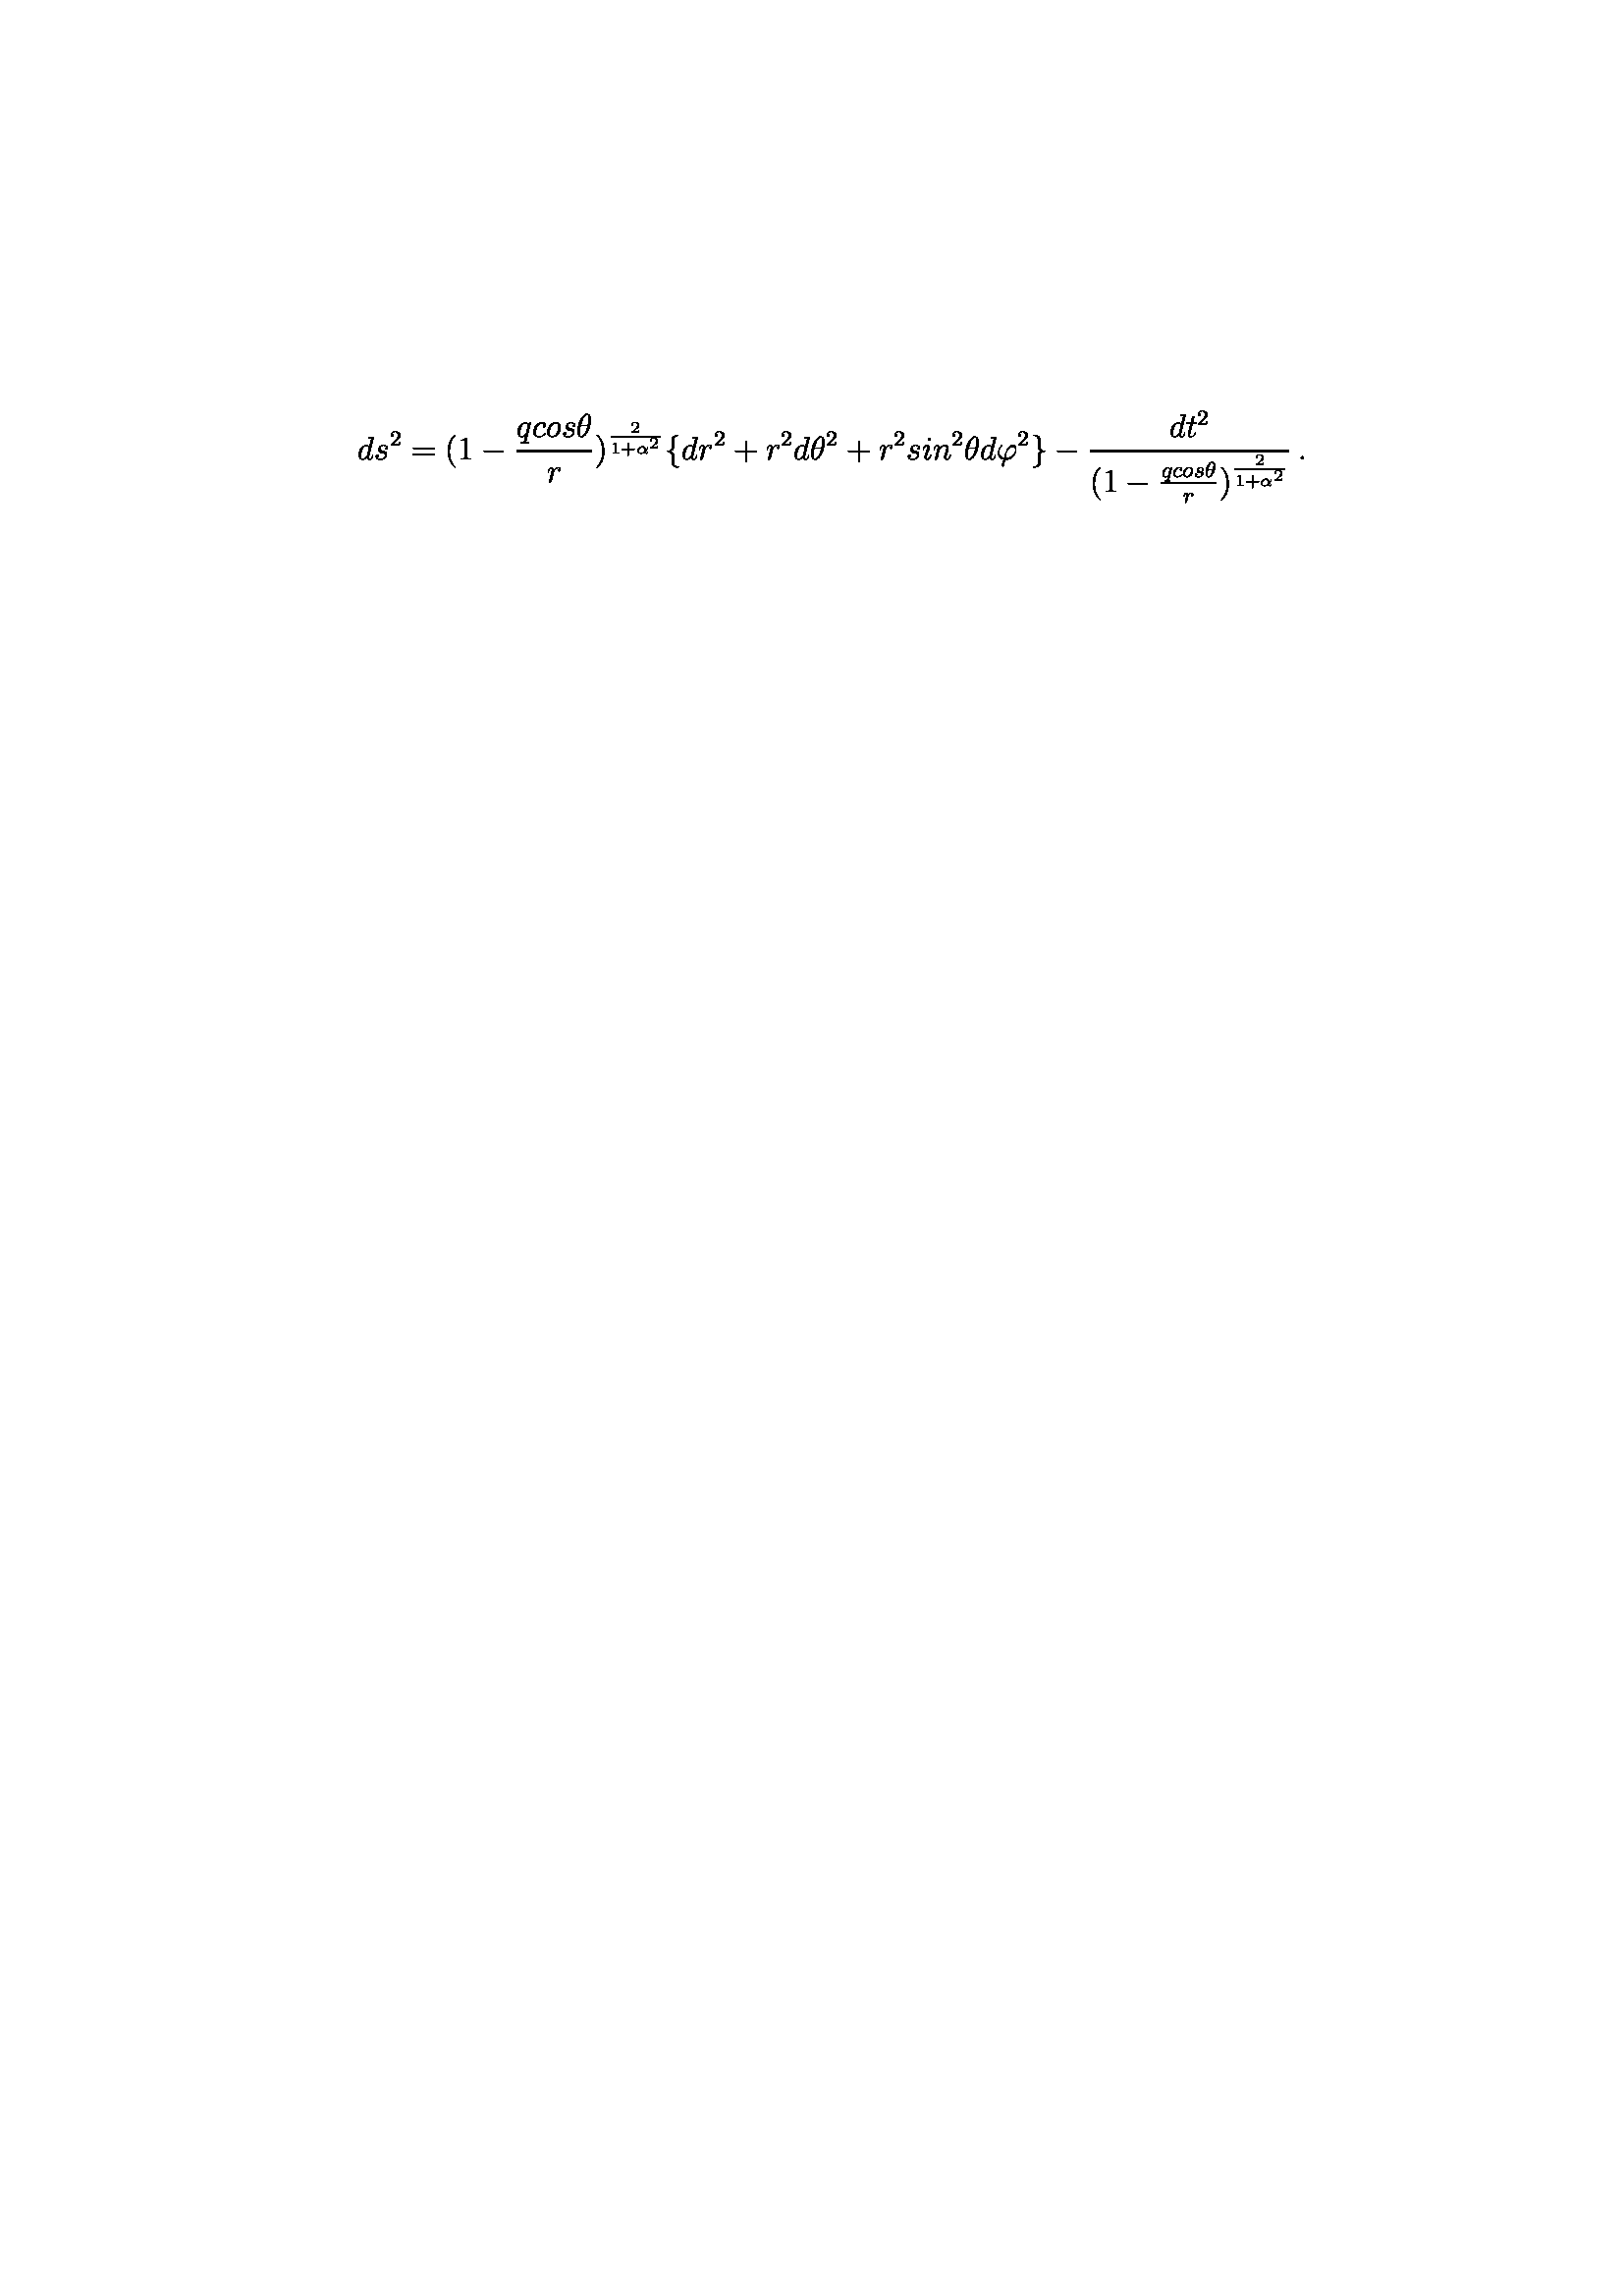

Перевод: \label{maxwell}{\cal \partial_{i} dt^2 dt^2 \gamma} ~\tilde{f}(a,b) \label{qe}
 \sim } \rangle_{\mbox{\tiny + \pi} s)}{(s-\bar (\varpi <end> 


Что должно получиться: ds^{2}=(1-{qcos\theta\overr})^{2\over1+\alpha^{2}}\lbracedr^2+r^2d\theta^2+r^2sin^2\thetad\varphi^2\rbrace-{dt^2\over(1-{qcos\theta\overr})^{2\over1+\alpha^{2}}}\,.\label{eq:sps1}


Расстояние Левенштейна: 20


In [ ]:
translate(X_test[0], y_train[0])

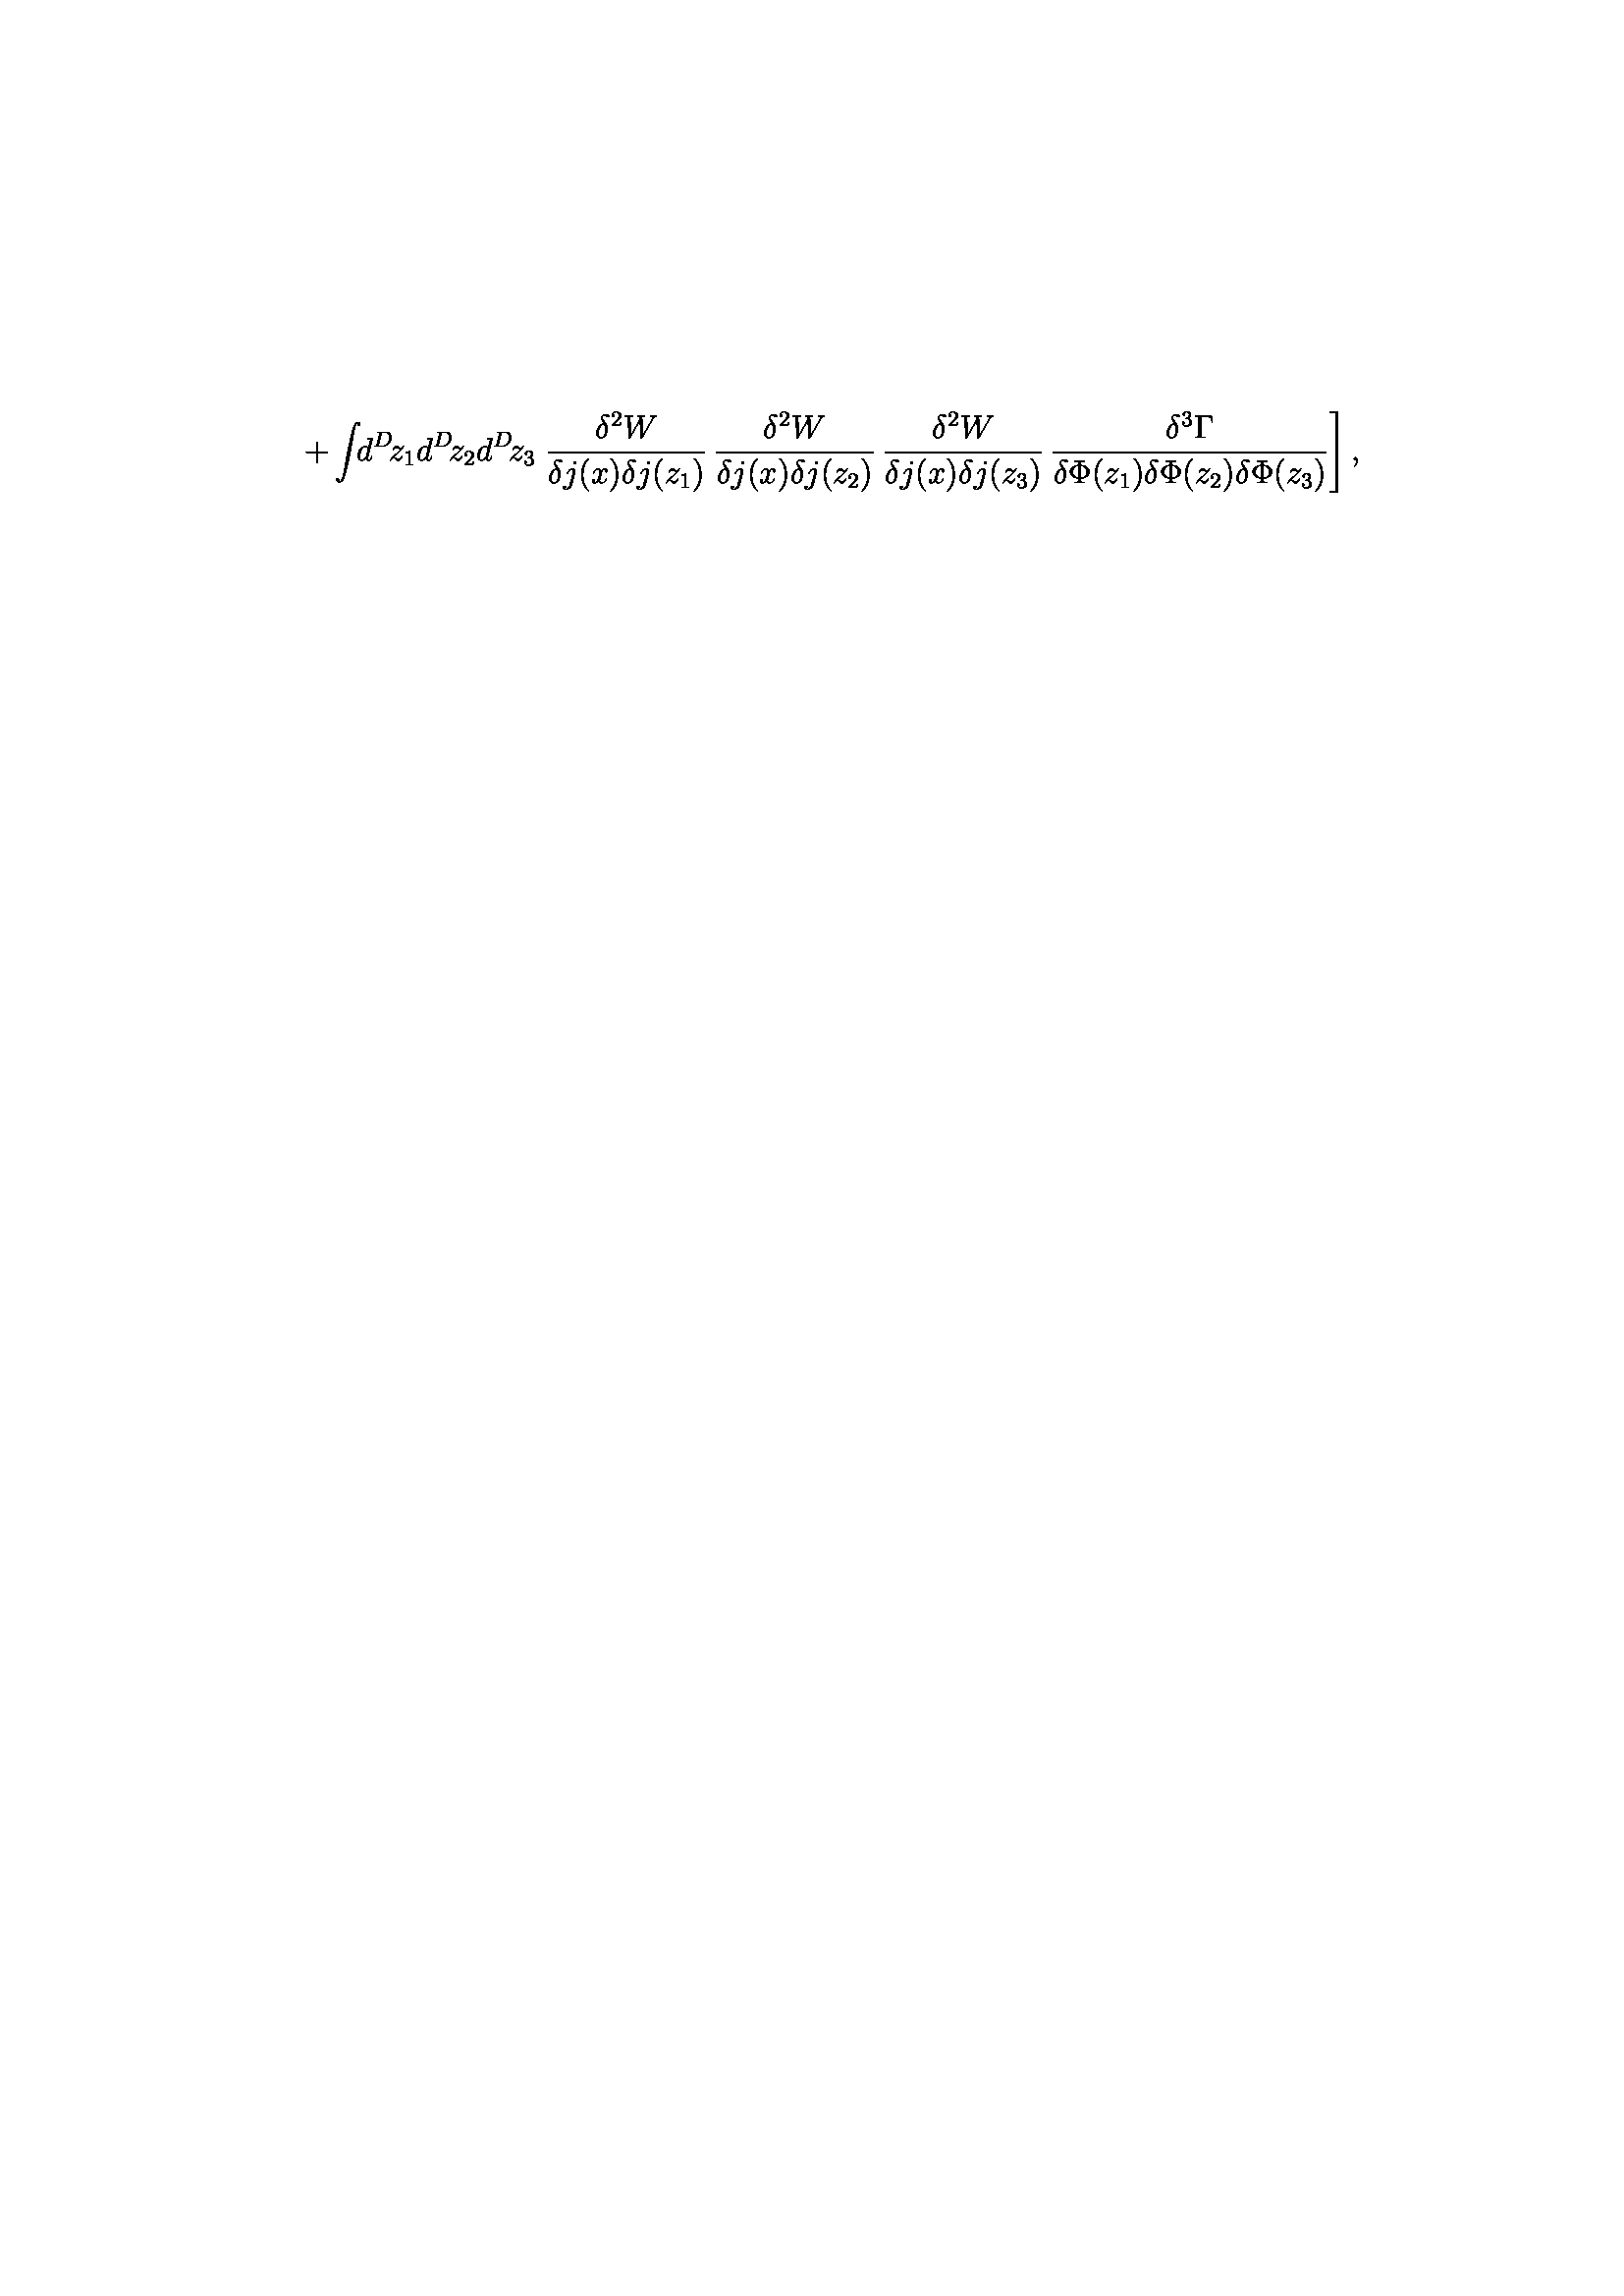

Перевод: f^2}\int\;d^4x\,\frac{d^4q}{\left(2\pi\right)^4} \label{ese13}\tilde{s}^{0}(x,y) \label{13}
 <end> 


Что должно получиться: +\int\!\!d^d\!z_1d^d\!z_2d^d\!z_3\left.\frac{\delta^2w}{\deltaj(x)\deltaj(z_1)}\,\frac{\delta^2w}{\deltaj(x)\deltaj(z_2)}\,\frac{\delta^2w}{\deltaj(x)\deltaj(z_3)}\,\frac{\delta^3\gamma}{\delta\phi(z_1)\delta\phi(z_2)\delta\phi(z_3)}\right],


Расстояние Левенштейна: 33


In [ ]:
translate(X_test[5], y_train[5])

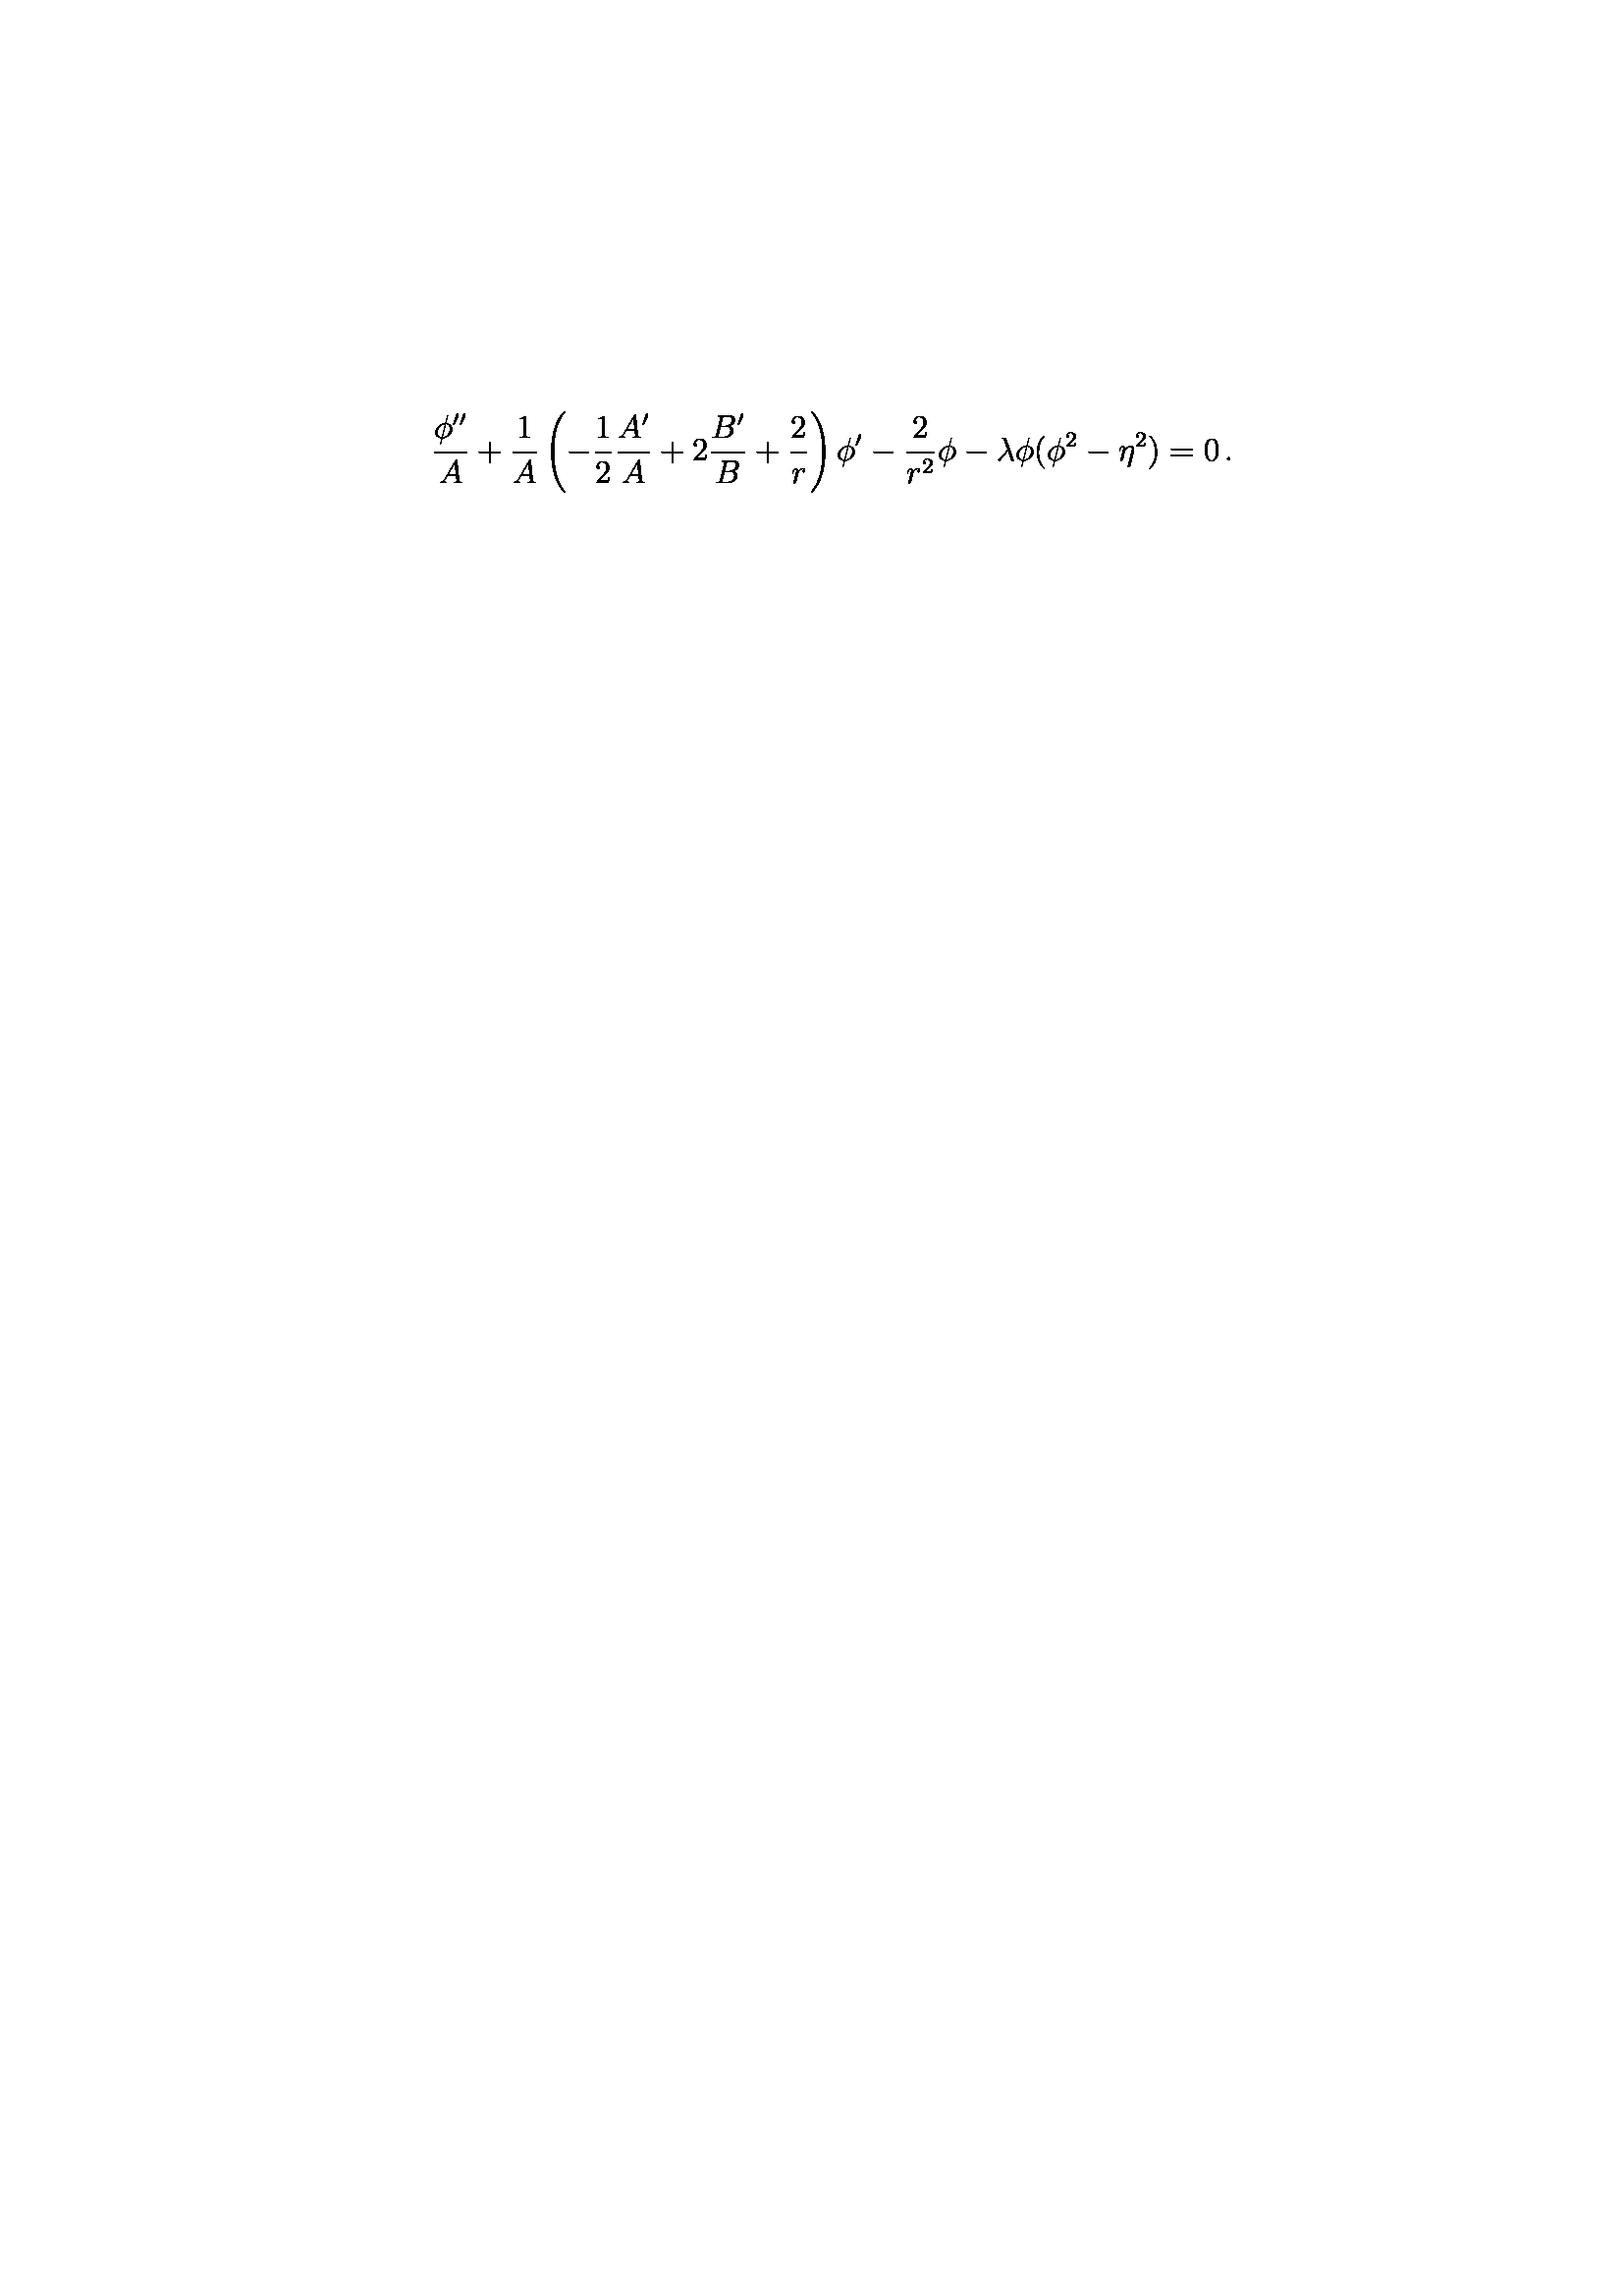

Перевод: \label {\alpha s)]}+n,
 b}^2}{3} \exp j(z_3)} (1 \frac{(t+t^*)z^{*3}(1-a|z|^2)} dy^{a'} j(x) - x}^2 n\in (\varpi {e^{\tilde{k}/2}p''(y)},\mbox{ +r^2 \right] \over u}\left[ \label{9}
 } z)\,t+u(z,\bar ,
 c_t \over x}^2 ~k_0(d^2 <end> 


Что должно получиться: {\phi''\overa}+{1\overa}\left(-{1\over2}{a'\overa}+2{b'\overb}+{2\overr}\right)\phi'-{2\overr^2}\phi-\lambda\phi(\phi^2-\eta^2)=0\,.\label{eq=phi}


Расстояние Левенштейна: 14


In [ ]:
translate(X_test[7], y_train[7])